In [1]:
from importlib import reload
import sys
sys.path.insert(0, '../')

# sys.path.remove("/home/users/yixiuz/.local/lib/python3.9/site-packages")
sys.path.insert(0, "/home/groups/swl1/yixiuz/torch_fid/lib/python3.9/site-packages")
sys.path.insert(0, "/home/groups/swl1/yixiuz/torch_fid/bin")

In [2]:
# reload(pd)

In [42]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
# Custom legend creation
from matplotlib.lines import Line2D

In [4]:
import seaborn as sns
palette = sns.color_palette("tab10", n_colors=10)
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [5]:
# Define styles
style = {
    "corrector_colors": {'birthdeath': palette[1], 'barker': palette[4], 'mpf': palette[6]},
    "method_linestyles": {'tauleaping': '--', 'gillespies': '-'},
    "c_steps_linewidths": {1: 1, 2: 2},
}


In [6]:
def lighten_color(rgb, amount):
    r, g, b = rgb
    r = (r + amount * (1 - r))
    g = (g + amount * (1 - g))
    b = (b + amount * (1 - b))
    return (r, g, b)

In [69]:
y_labels = {
    'error_rate': 'Proportion of Errors',
    'h_dist': 'Hellinger Distance',
    'outlier_rate': 'Proportion of Outliers'
}

legend_labels = {
#     "barker": "Barker",
#     "mpf": "MPF",
#     "birthdeath": "FB",
    "barker": "Informed:Barker",
    "mpf": "Informed:MPF",
    "birthdeath": "Uninformed",
    "tauleaping": r"$\tau$-leaping",
    "gillespies": r"$k$-Gillespie's",
    "1": "1 corrector step",
    "2": "2 corrector steps",
}

def tag_to_label(tag):
    label = tag

    # Remove the final dash and number
    label = '-'.join(label.rsplit('-', 1)[:-1])
    label = label.replace("birthdeath", "FB")
    label = label.replace("mpf", "MPF")
    label = label.replace("barker", "Barker")
    label = label.replace("tauleaping", r"$\tau$-leaping")
    label = label.replace("gillespies", r"$k$-Gillespie's")
    return label

def make_plot(file_name, metric, tag_filters=None, style=None, show_legends=True,
              tag_to_label=tag_to_label, xticks=None, std_scale=1, figsize=(10,6)):
    results_df = pd.read_csv(file_name)

    if tag_filters is not None:
        results_df = results_df[results_df['tag'].isin(tag_filters)]
    
    # Group data by method and nfe
    grouped = results_df.groupby(['tag', 'nfe'])

    # Calculate mean and standard deviation for metric1
    mean_metric1 = grouped[metric].mean().unstack()
    std_metric1 = grouped[metric].std().unstack()
    
    # Plot the mean metric1 with cost on x-axis
    fig, ax = plt.subplots(figsize=figsize)
    
    ts = [legend_labels["birthdeath"], 
          legend_labels["barker"], 
          legend_labels["mpf"]]
    ms = [r"$\tau$-leaping", r"$k$-Gillespie's"]
    cs = ["1 step", "2 steps"]
    
    for tag in mean_metric1.index:
        if tag_to_label is not None:
            label = tag_to_label(tag)
            print(tag, "->", label)
        else:
            label = tag
            print(tag)
            
        mean_values = mean_metric1.loc[tag].dropna()
        std_values = std_metric1.loc[tag].dropna()
        
        row = results_df.loc[results_df["tag"] == tag].iloc[0]
        t = row["corrector"]
        m = row["method"]
        c = row["c_steps"]
        
        color = style["corrector_colors"][t]
        linestyle = style["method_linestyles"][m]
        linewidth = style["c_steps_linewidths"][c]
        
        h = ax.plot(mean_values.index, mean_values, #label=f'{label}',
                   color=color, linestyle=linestyle, linewidth=linewidth)[0]
        ax.scatter(mean_values.index, mean_values, s=10, color=color)
        ax.fill_between(mean_values.index, 
                         mean_values - std_values * std_scale, 
                         mean_values + std_values * std_scale, 
                        color=color,
                         alpha=0.2)
        
    t_legend = [Line2D([0], [0], color=color, lw=2) for color in style["corrector_colors"].values()]
    legend_1 = ax.legend(t_legend, ts, loc='lower left', bbox_to_anchor=(0,0))
    
    m_legend = [Line2D([0], [0], color='grey', linestyle=linestyle, lw=2) for linestyle in style["method_linestyles"].values()]
    legend_2 = ax.legend(m_legend, ms, loc='lower left', bbox_to_anchor=(0,.155))
    
    c_legend = [Line2D([0], [0], color='grey', lw=linewidth) for linewidth in style["c_steps_linewidths"].values()]
    legend_3 = ax.legend(c_legend, cs, loc='lower left', bbox_to_anchor=(0,.28))
    
    if show_legends:
        ax.add_artist(legend_1)
        ax.add_artist(legend_2)
        ax.add_artist(legend_3)

    plt.xscale('log')
    plt.xlabel('NFE', fontsize="large")
    if metric in y_labels.keys():
        plt.ylabel(y_labels[metric], fontsize="large")
    else:
        plt.ylabel(metric, fontsize="large")

    plt.grid(True)
    if xticks is None:
        plt.xticks([64, 128, 256, 512, 1024])
    else:
        plt.xticks(xticks)
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())
    fig.set_facecolor("white")
    ax.set_facecolor("white")
    return fig, ax
    
# Define a function to create tags based on the method and c_steps
def create_tag(row):
    return f"{row['method']}+{row['c_steps']}{row['corrector']}-{row['c_stepsize']}"

def update_tags(file_name):
    # Read the existing data
    if os.path.exists(file_name):
        df = pd.read_csv(file_name)
    else:
        raise FileNotFoundError(f"{file_name} does not exist.")

    # Apply the tag function to each row
    df['tag'] = df.apply(create_tag, axis=1)

    # Save the updated data back to the CSV file
    df.to_csv(file_name, index=False)

    print("Tags added and results saved to", file_name)


# Experiment 1: countdown

In [70]:
results_file = "results/countdown_results_tagged.csv"

update_tags(results_file)

Tags added and results saved to results/countdown_results_tagged.csv


gillespies+1barker-1.0 -> $k$-Gillespie's+1Barker
gillespies+1birthdeath-0.1 -> $k$-Gillespie's+1FB
gillespies+1mpf-2.0 -> $k$-Gillespie's+1MPF
gillespies+2barker-1.0 -> $k$-Gillespie's+2Barker
gillespies+2birthdeath-0.1 -> $k$-Gillespie's+2FB
gillespies+2mpf-2.0 -> $k$-Gillespie's+2MPF
tauleaping+1barker-1.0 -> $\tau$-leaping+1Barker
tauleaping+1birthdeath-0.1 -> $\tau$-leaping+1FB
tauleaping+1mpf-2.0 -> $\tau$-leaping+1MPF
tauleaping+2barker-1.0 -> $\tau$-leaping+2Barker
tauleaping+2birthdeath-0.1 -> $\tau$-leaping+2FB
tauleaping+2mpf-2.0 -> $\tau$-leaping+2MPF


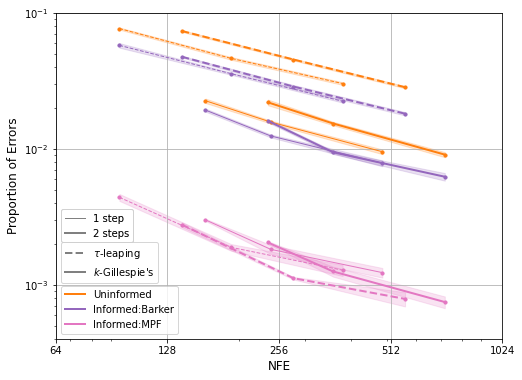

In [71]:
fig2, ax2 = make_plot(results_file, "error_rate", style=style, show_legends=True, figsize=(8,6))
ax2.set_yscale('log')
ax2.set_ylim((4e-4, 1e-1))
fig2.savefig('countdown_all_err_tall.pdf', dpi=300, bbox_inches='tight')

gillespies+1barker-1.0 -> $k$-Gillespie's+1Barker
gillespies+1birthdeath-0.1 -> $k$-Gillespie's+1FB
gillespies+1mpf-2.0 -> $k$-Gillespie's+1MPF
gillespies+2barker-1.0 -> $k$-Gillespie's+2Barker
gillespies+2birthdeath-0.1 -> $k$-Gillespie's+2FB
gillespies+2mpf-2.0 -> $k$-Gillespie's+2MPF
tauleaping+1barker-1.0 -> $\tau$-leaping+1Barker
tauleaping+1birthdeath-0.1 -> $\tau$-leaping+1FB
tauleaping+1mpf-2.0 -> $\tau$-leaping+1MPF
tauleaping+2barker-1.0 -> $\tau$-leaping+2Barker
tauleaping+2birthdeath-0.1 -> $\tau$-leaping+2FB
tauleaping+2mpf-2.0 -> $\tau$-leaping+2MPF
gillespies+1barker-1.0 -> $k$-Gillespie's+1Barker
gillespies+1birthdeath-0.1 -> $k$-Gillespie's+1FB
gillespies+1mpf-2.0 -> $k$-Gillespie's+1MPF
gillespies+2barker-1.0 -> $k$-Gillespie's+2Barker
gillespies+2birthdeath-0.1 -> $k$-Gillespie's+2FB
gillespies+2mpf-2.0 -> $k$-Gillespie's+2MPF
tauleaping+1barker-1.0 -> $\tau$-leaping+1Barker
tauleaping+1birthdeath-0.1 -> $\tau$-leaping+1FB
tauleaping+1mpf-2.0 -> $\tau$-leaping+1MPF
t

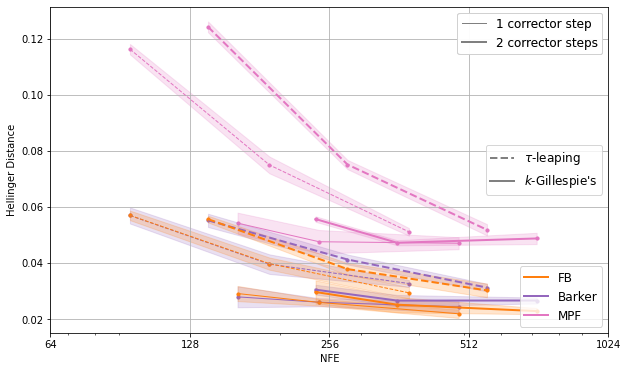

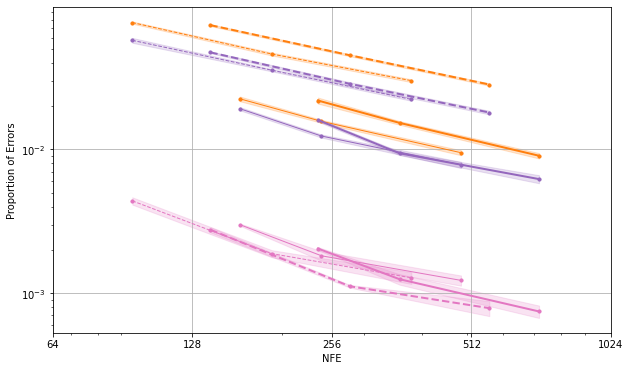

In [51]:
fig1, ax1 = make_plot(results_file, "h_dist", style=style, show_legends=True)
fig2, ax2 = make_plot(results_file, "error_rate", style=style, show_legends=False)
ax2.set_yscale('log')
print(ax2.get_legend().remove())
fig1.savefig('countdown_all_hell.pdf', dpi=300, bbox_inches='tight')
fig2.savefig('countdown_all_err.pdf', dpi=300, bbox_inches='tight')

In [175]:
barker_v_birthdeath = [
    "gillespies+1barker-1.0",
    "gillespies+1birthdeath-0.1",
    "tauleaping+1barker-1.0",
    "tauleaping+1birthdeath-0.1",
    "gillespies+2barker-1.0",
    "gillespies+2birthdeath-0.1",
    "tauleaping+2barker-1.0",
    "tauleaping+2birthdeath-0.1"
]

mpf_v_birthdeath = [
    "gillespies+1mpf-2.0",
    "gillespies+1birthdeath-0.1",
    "tauleaping+1mpf-2.0",
    "tauleaping+1birthdeath-0.1",
    "gillespies+2mpf-2.0",
    "gillespies+2birthdeath-0.1",
    "tauleaping+2mpf-2.0",
    "tauleaping+2birthdeath-0.1"
]

gillespies+1birthdeath-0.1 -> Gillespies+1FB
gillespies+1mpf-2.0 -> Gillespies+1MPF
gillespies+2birthdeath-0.1 -> Gillespies+2FB
gillespies+2mpf-2.0 -> Gillespies+2MPF
tauleaping+1birthdeath-0.1 -> $\tau$-leaping+1FB
tauleaping+1mpf-2.0 -> $\tau$-leaping+1MPF
tauleaping+2birthdeath-0.1 -> $\tau$-leaping+2FB
tauleaping+2mpf-2.0 -> $\tau$-leaping+2MPF
gillespies+1birthdeath-0.1 -> Gillespies+1FB
gillespies+1mpf-2.0 -> Gillespies+1MPF
gillespies+2birthdeath-0.1 -> Gillespies+2FB
gillespies+2mpf-2.0 -> Gillespies+2MPF
tauleaping+1birthdeath-0.1 -> $\tau$-leaping+1FB
tauleaping+1mpf-2.0 -> $\tau$-leaping+1MPF
tauleaping+2birthdeath-0.1 -> $\tau$-leaping+2FB
tauleaping+2mpf-2.0 -> $\tau$-leaping+2MPF


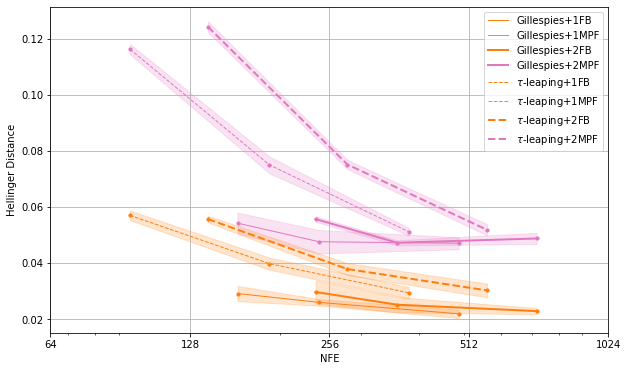

<Figure size 432x288 with 0 Axes>

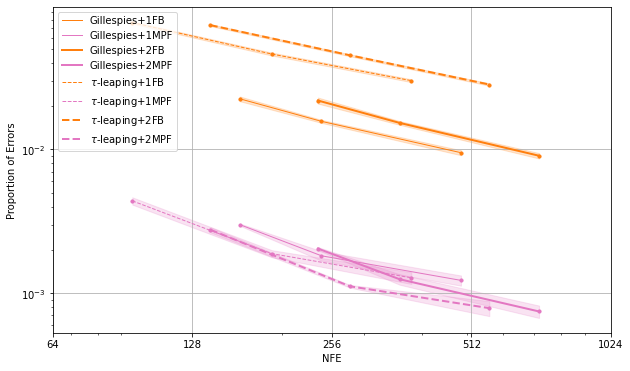

In [176]:
fig1, ax1 = make_plot(results_file, "h_dist", mpf_v_birthdeath,style=style)
plt.figure()
fig2, ax2 = make_plot(results_file, "error_rate", mpf_v_birthdeath, style=style)
ax2.set_yscale("log")

fig1.savefig('countdown_mpf_v_fb_hell.pdf', dpi=300, bbox_inches='tight')
fig2.savefig('countdown_mpf_v_fb_err.pdf', dpi=300, bbox_inches='tight')

gillespies+1barker-1.0 -> Gillespies+1Barker
gillespies+1birthdeath-0.1 -> Gillespies+1FB
gillespies+2barker-1.0 -> Gillespies+2Barker
gillespies+2birthdeath-0.1 -> Gillespies+2FB
tauleaping+1barker-1.0 -> $\tau$-leaping+1Barker
tauleaping+1birthdeath-0.1 -> $\tau$-leaping+1FB
tauleaping+2barker-1.0 -> $\tau$-leaping+2Barker
tauleaping+2birthdeath-0.1 -> $\tau$-leaping+2FB
gillespies+1barker-1.0 -> Gillespies+1Barker
gillespies+1birthdeath-0.1 -> Gillespies+1FB
gillespies+2barker-1.0 -> Gillespies+2Barker
gillespies+2birthdeath-0.1 -> Gillespies+2FB
tauleaping+1barker-1.0 -> $\tau$-leaping+1Barker
tauleaping+1birthdeath-0.1 -> $\tau$-leaping+1FB
tauleaping+2barker-1.0 -> $\tau$-leaping+2Barker
tauleaping+2birthdeath-0.1 -> $\tau$-leaping+2FB


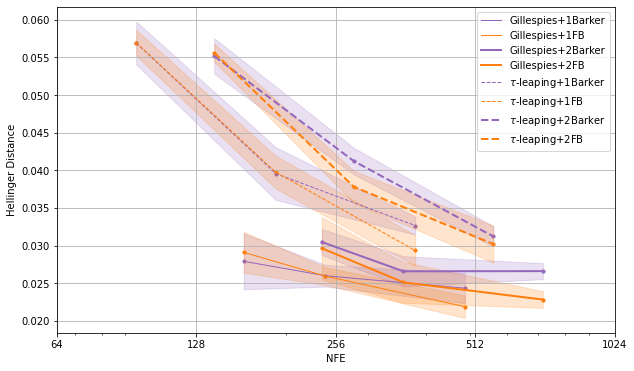

<Figure size 432x288 with 0 Axes>

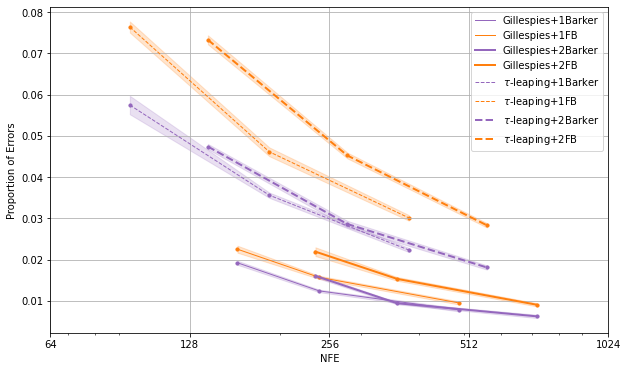

In [177]:
fig1, ax1 = make_plot(results_file, "h_dist", barker_v_birthdeath,style=style)
plt.figure()
fig2, ax2 = make_plot(results_file, "error_rate", barker_v_birthdeath, style=style)
# ax2.set_yscale('log')

fig1.savefig('countdown_barker_v_fb_hell.pdf', dpi=300, bbox_inches='tight')
fig2.savefig('countdown_barker_v_fb_err.pdf', dpi=300, bbox_inches='tight')

# Experiment 2: pianoroll

In [208]:
# I don't know what we're plotting here honestly.
# Let's just get the figures and see lol

piano_results_file = "piano_results_tagged.csv"

update_tags(piano_results_file)

Tags added and results saved to piano_results_tagged.csv


In [212]:
piano_barker_v_fb = [
#     "tauleaping+1barker-0.05",
    "tauleaping+1barker-0.1",
    "tauleaping+1birthdeath-0.1",
#     "tauleaping+1birthdeath-1.0",
#         "gillespies+1birthdeath-1.0",
        "gillespies+1barker-0.1",
]

piano_mpf_v_fb = [
    "tauleaping+1mpf-0.1",
    "tauleaping+1mpf-1.0",
    "tauleaping+1birthdeath-0.1",
    "tauleaping+1birthdeath-1.0",
    "gillespies+1birthdeath-1.0",
    "gillespies+1mpf-0.1", 
    "gillespies+1mpf-1.0",
]

gillespies+1barker-0.1
gillespies+1birthdeath-1.0
gillespies+1mpf-0.1
gillespies+1mpf-1.0
tauleaping+1barker-0.05
tauleaping+1barker-0.1
tauleaping+1birthdeath-0.1
tauleaping+1birthdeath-1.0
tauleaping+1mpf-0.1
tauleaping+1mpf-1.0
gillespies+1barker-0.1
gillespies+1birthdeath-1.0
gillespies+1mpf-0.1
gillespies+1mpf-1.0
tauleaping+1barker-0.05
tauleaping+1barker-0.1
tauleaping+1birthdeath-0.1
tauleaping+1birthdeath-1.0
tauleaping+1mpf-0.1
tauleaping+1mpf-1.0


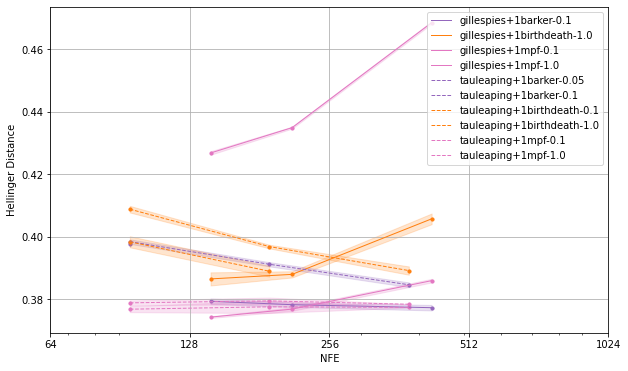

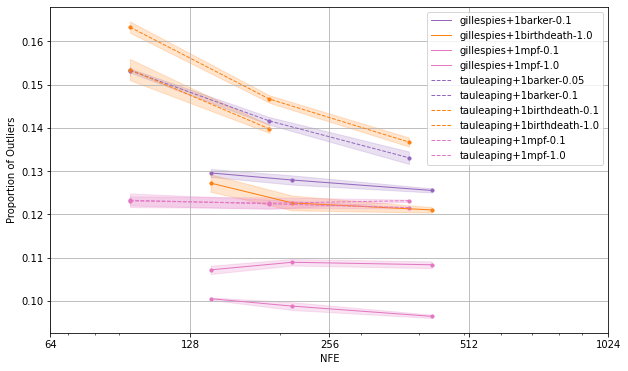

In [214]:
fig1, ax1 = make_plot(piano_results_file, "h_dist",
                      style=style, tag_to_label=None)
fig2, ax2 = make_plot(piano_results_file, "outlier_rate",
                      style=style, tag_to_label=None)

gillespies+1birthdeath-1.0
gillespies+1mpf-0.1
gillespies+1mpf-1.0
tauleaping+1birthdeath-0.1
tauleaping+1birthdeath-1.0
tauleaping+1mpf-0.1
tauleaping+1mpf-1.0
gillespies+1birthdeath-1.0
gillespies+1mpf-0.1
gillespies+1mpf-1.0
tauleaping+1birthdeath-0.1
tauleaping+1birthdeath-1.0
tauleaping+1mpf-0.1
tauleaping+1mpf-1.0


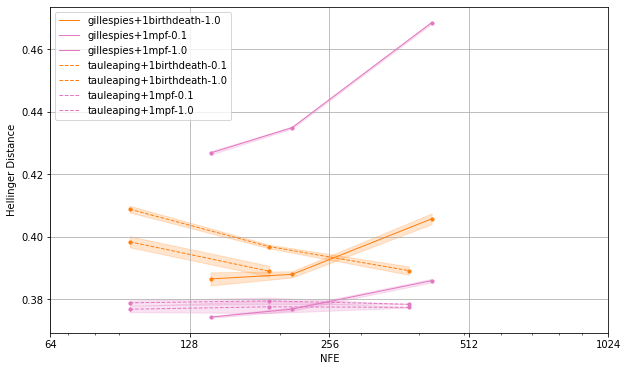

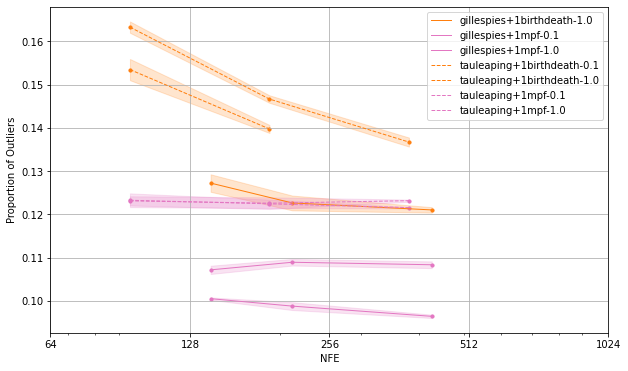

In [213]:
fig1, ax1 = make_plot(piano_results_file, "h_dist", piano_mpf_v_fb,
                      style=style, tag_to_label=None)
fig2, ax2 = make_plot(piano_results_file, "outlier_rate", piano_mpf_v_fb,
                      style=style, tag_to_label=None)

Just present it as a table, lol

In [284]:
def get_mean_and_std(file_name, filter, metric):
    df = pd.read_csv(file_name)

    # Take the best method from Gillespies and Tauleaping and just be done.
    # Filter the DataFrame for the specific tag
    filtered_df = df[filter(df)]

    # Compute the mean and standard deviation for metric1 and metric2
    mean = filtered_df[metric].mean()
    std = filtered_df[metric].std()
    
    print(metric + r": {:.4f}\pm{:.4f}".format(mean, std))
    
    return mean, std

gill_best_filter = lambda df: (df["tag"] == "gillespies+1mpf-0.1") & (df["g_steps"] == 3)
taul_best_filter = lambda df: (df["tag"] == "tauleaping+1mpf-0.1") & (df["tau_steps"] == 50)
print("Best Gillespies: ")
_ = get_mean_and_std(piano_results_file, gill_best_filter, "h_dist")
_ = get_mean_and_std(piano_results_file, gill_best_filter, "outlier_rate")
_ = get_mean_and_std(piano_results_file, gill_best_filter, "nfe")
print("Best tau-leaping: ")
_ = get_mean_and_std(piano_results_file, taul_best_filter, "h_dist")
_ = get_mean_and_std(piano_results_file, taul_best_filter, "outlier_rate")
_ = get_mean_and_std(piano_results_file, taul_best_filter, "nfe")

Best Gillespies: 
h_dist: 0.3744\pm0.0003
outlier_rate: 0.1071\pm0.0010
nfe: 141.8667\pm0.0000
Best tau-leaping: 
h_dist: 0.3769\pm0.0009
outlier_rate: 0.1231\pm0.0011
nfe: 95.0000\pm0.0000


In [283]:
(224 // 3+1) + (224 // 3+1) * 0.9

142.5

# Experiment 3: sequence datasets

In [36]:
# I... honestly don't know what to expect...
gene_results_file = "results/gene_results_tagged.csv"
update_tags(gene_results_file)

Tags added and results saved to results/gene_results_tagged.csv


In [9]:
all_tags = [
"gillespies+1barker-0.1",
"gillespies+1birthdeath-0.1",
"gillespies+1mpf-0.1",
"gillespies+2barker-0.1",
"gillespies+2birthdeath-0.1",
"gillespies+2mpf-0.1",
"tauleaping+1barker-0.1",
"tauleaping+1birthdeath-0.1",
"tauleaping+1mpf-0.1",
"tauleaping+2barker-0.1",
"tauleaping+2birthdeath-0.1",
"tauleaping+2mpf-0.1",
]

good_tags = [
"gillespies+1barker-0.1",
"gillespies+1birthdeath-0.1",
"gillespies+1mpf-0.1",
"gillespies+2barker-0.1",
"gillespies+2birthdeath-0.1",
"gillespies+2mpf-0.1",
# "tauleaping+1barker-0.1",
# "tauleaping+1birthdeath-0.1",
"tauleaping+1mpf-0.1",
# "tauleaping+2barker-0.1",
# "tauleaping+2birthdeath-0.1",
"tauleaping+2mpf-0.1",
]

bad_tags = [
"tauleaping+1barker-0.1",
"tauleaping+1birthdeath-0.1",
"tauleaping+2barker-0.1",
"tauleaping+2birthdeath-0.1",
]

tags = good_tags
xticks = [32, 64, 128, 256]

gillespies+1barker-0.1
gillespies+1birthdeath-0.1
gillespies+1mpf-0.1
gillespies+2barker-0.1
gillespies+2birthdeath-0.1
gillespies+2mpf-0.1
tauleaping+1mpf-0.1
tauleaping+2mpf-0.1
gillespies+1barker-0.1
gillespies+1birthdeath-0.1
gillespies+1mpf-0.1
gillespies+2barker-0.1
gillespies+2birthdeath-0.1
gillespies+2mpf-0.1
tauleaping+1mpf-0.1
tauleaping+2mpf-0.1


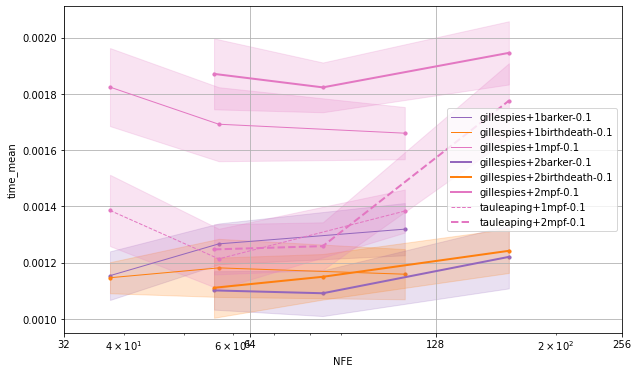

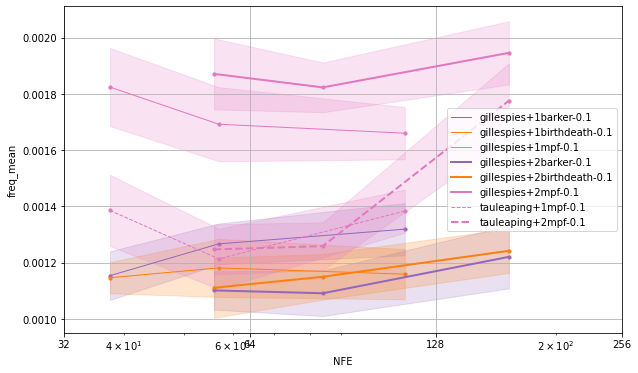

In [9]:
fig1, ax1 = make_plot(gene_results_file, "time_mean", tags,
                      xticks=xticks, std_scale = .2,
                      style=style, tag_to_label=None)
fig2, ax2 = make_plot(gene_results_file, "freq_mean", tags,
                      xticks=xticks, std_scale = .2,
                      style=style, tag_to_label=None)

gillespies+1barker-0.1
gillespies+1birthdeath-0.1
gillespies+1mpf-0.1
gillespies+2barker-0.1
gillespies+2birthdeath-0.1
gillespies+2mpf-0.1
tauleaping+1mpf-0.1
tauleaping+2mpf-0.1
gillespies+1barker-0.1
gillespies+1birthdeath-0.1
gillespies+1mpf-0.1
gillespies+2barker-0.1
gillespies+2birthdeath-0.1
gillespies+2mpf-0.1
tauleaping+1mpf-0.1
tauleaping+2mpf-0.1


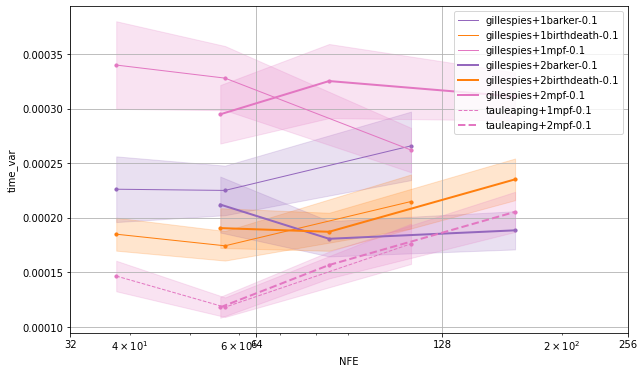

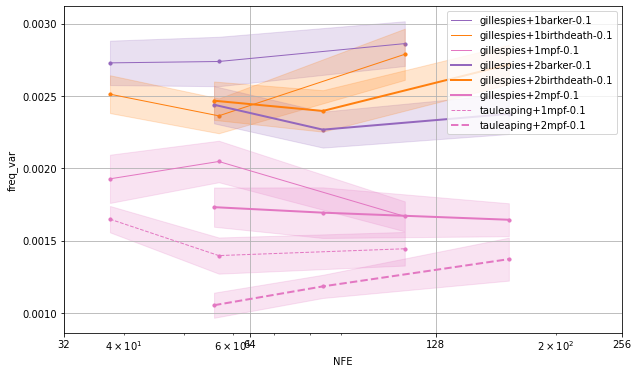

In [10]:
fig1, ax1 = make_plot(gene_results_file, "time_var", tags,
                      xticks=xticks, std_scale = .2,
                      style=style, tag_to_label=None)
# ax1.set_yscale("log")
fig2, ax2 = make_plot(gene_results_file, "freq_var", tags,
                      xticks=xticks, std_scale = .2,
                      style=style, tag_to_label=None)
# ax2.set_yscale("log")

gillespies+1barker-0.1
gillespies+1birthdeath-0.1
gillespies+1mpf-0.1
gillespies+2barker-0.1
gillespies+2birthdeath-0.1
gillespies+2mpf-0.1
tauleaping+1mpf-0.1
tauleaping+2mpf-0.1
gillespies+1barker-0.1
gillespies+1birthdeath-0.1
gillespies+1mpf-0.1
gillespies+2barker-0.1
gillespies+2birthdeath-0.1
gillespies+2mpf-0.1
tauleaping+1mpf-0.1
tauleaping+2mpf-0.1


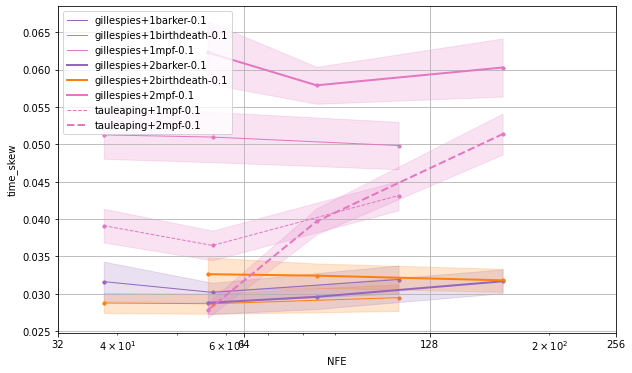

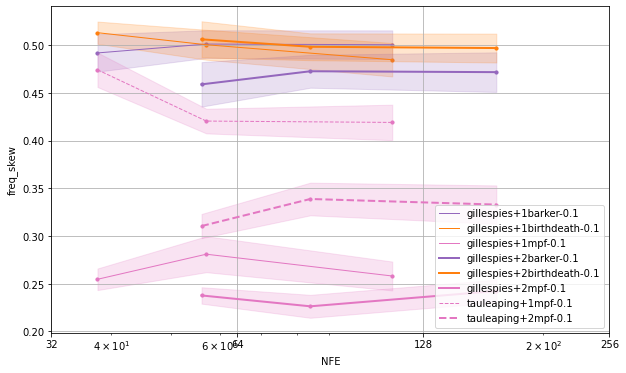

In [11]:
fig1, ax1 = make_plot(gene_results_file, "time_skew", tags,
                      xticks=xticks, std_scale = .2,
                      style=style, tag_to_label=None)
# ax1.set_yscale("log")
fig2, ax2 = make_plot(gene_results_file, "freq_skew", tags,
                      xticks=xticks, std_scale = .2,
                      style=style, tag_to_label=None)
# ax2.set_yscale("log")

In [37]:
fig1, ax1 = make_plot(gene_results_file, "time_kurt", tags,
                      xticks=xticks, std_scale = .2,
                      style=style, tag_to_label=None)
# ax1.set_yscale("log")
fig2, ax2 = make_plot(gene_results_file, "freq_kurt", tags,
                      xticks=xticks, std_scale = .2,
                      style=style, tag_to_label=None)
# ax2.set_yscale("log")

NameError: name 'tags' is not defined

In [38]:
def dataframe_to_latex(df):
#     # Select the specified columns
#     selected_columns = ["freq_mean", "freq_var", "freq_skew", "freq_kurt"]
    
#     # Ensure the DataFrame contains the required columns
#     df = df[selected_columns]
    
    # Convert the DataFrame to a LaTeX table
    latex_table = df.to_latex(index=False, column_format='lcccc', 
                              header=True, float_format="%.3f", escape=False)
    
    return latex_table

def tag_to_table(tag):
    label = tag

    # Remove the final dash and number
    label = '-'.join(label.rsplit('-', 1)[:-1])
    label = label.replace("birthdeath", "FB")
    label = label.replace("mpf", "MPF")
    label = label.replace("barker", "Barker")
    label = label.replace("tauleaping", r"$\tau$-leaping")
    label = label.replace("gillespies", "$k$-Gillespies")
    
    id = label.find('+')
    label = label[:id] + " + " + label[id+2:]
    
    return label

def process_dataframe(df, metrics):
    # Group by 'tag' and calculate mean and std for each metric
    grouped = df.groupby('tag').agg(['mean', 'std'])

    # Flatten the MultiIndex columns
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]

    # Create a new DataFrame with formatted strings
    formatted_data = {}
    for metric in metrics:
        mean_col = f'{metric}_mean'
        std_col = f'{metric}_std'
        formatted_data[metric] = grouped.apply(lambda row: f"{row[mean_col]:.1e} ± {row[std_col]:.1e}", axis=1)

    # Convert the dictionary to a DataFrame
    formatted_df = pd.DataFrame(formatted_data)

    # Reset index for a cleaner look
#     formatted_df.reset_index(inplace=True)
    
    for metric in metrics:
        min_index = grouped[f'{metric}_mean'].idxmin()
        formatted_df.loc[min_index, metric] = f"\\textbf{{{formatted_df.loc[min_index, metric]}}}"
        
    return formatted_df
    
df = pd.read_csv(gene_results_file)

df = df.loc[(df["c_steps"]==2) & (df["nfe"]==56.0)]
metrics = ["freq_mean", "freq_var", "freq_skew", "freq_kurt"]
df = df[["tag"] + metrics]

processed_df = process_dataframe(df, metrics)

processed_df.reset_index(inplace=True)
processed_df.columns = ["Method", "Mean", "Variance", "Skewness", "Kurtosis"]
processed_df["Method"] = processed_df["Method"].apply(tag_to_table)
print(dataframe_to_latex(processed_df))

\begin{tabular}{lcccc}
\toprule
Method & Mean & Variance & Skewness & Kurtosis \\
\midrule
$k$-Gillespies + Barker & \textbf{1.1e-03 ± 3.4e-04} & 2.4e-03 ± 6.4e-04 & 4.6e-01 ± 1.2e-01 & 4.5e+00 ± 8.6e-01 \\
$k$-Gillespies + FB & 1.1e-03 ± 5.3e-04 & 2.5e-03 ± 6.6e-04 & 5.1e-01 ± 9.5e-02 & 4.9e+00 ± 8.0e-01 \\
$k$-Gillespies + MPF & 1.9e-03 ± 6.3e-04 & 1.7e-03 ± 6.8e-04 & \textbf{2.4e-01 ± 4.3e-02} & \textbf{2.7e+00 ± 9.7e-01} \\
$\tau$-leaping + Barker & 4.0e-03 ± 4.2e-04 & 8.1e-03 ± 7.4e-04 & 1.1e+00 ± 4.2e-02 & 1.2e+01 ± 3.8e-01 \\
$\tau$-leaping + FB & 3.8e-03 ± 5.4e-04 & 8.2e-03 ± 7.1e-04 & 1.0e+00 ± 3.6e-02 & 1.2e+01 ± 4.3e-01 \\
$\tau$-leaping + MPF & 1.2e-03 ± 4.5e-04 & \textbf{1.1e-03 ± 4.3e-04} & 3.1e-01 ± 6.3e-02 & 3.2e+00 ± 5.5e-01 \\
\bottomrule
\end{tabular}



# Making a bar plot for the gene expression data

In [39]:
from matplotlib.collections import PatchCollection

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor='none'))

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch

In [40]:
method_colors = style["corrector_colors"]
amount = .5
bar_colors = [method_colors["birthdeath"],
              lighten_color(method_colors["birthdeath"], amount),
              method_colors["barker"],
              lighten_color(method_colors["barker"], amount),
              method_colors["mpf"],
              lighten_color(method_colors["mpf"], amount),
             ]
bar_colors

[(1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7490196078431373, 0.5274509803921569),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7901960784313726, 0.7019607843137254, 0.8705882352941177),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9450980392156862, 0.7333333333333334, 0.8803921568627451)]

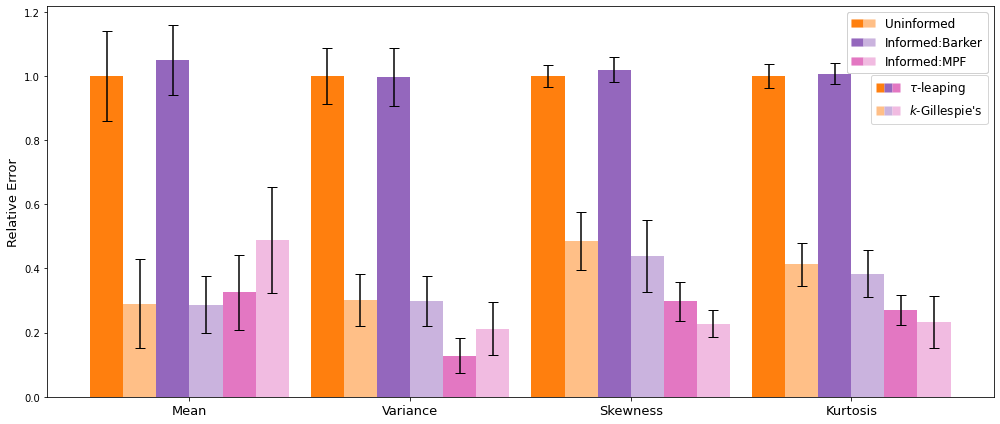

In [51]:
df = pd.read_csv(gene_results_file)

df = df.loc[(df["c_steps"]==2) & (df["nfe"]==56.0)]
metrics = ["freq_mean", "freq_var", "freq_skew", "freq_kurt"]
df = df[["tag"] + metrics]
df = df.groupby('tag').agg(['mean', 'std'])

lst = ["tauleaping+2birthdeath-0.1", 
       "gillespies+2birthdeath-0.1", 
       "tauleaping+2barker-0.1", 
       "gillespies+2barker-0.1",
       "tauleaping+2mpf-0.1", 
       "gillespies+2mpf-0.1",]
df = df.loc[lst]

df = df.reset_index()

df_mean = df.loc[:,(slice(None), "mean")]
df_mean.insert(0, "tag", df["tag"])
df_std = df.loc[:,(slice(None), "std")]
df_std.insert(0, "tag", df["tag"])

# Calculate relative errors
columns = ['mean', 'variance', 'skewness', 'kurtosis']
df_mean.columns = ['tag'] + columns
df_std.columns = ['tag'] + columns
baseline = df_mean.iloc[0,1:]
# print(baseline)

relative_errors = df_mean.iloc[:, 1:] / baseline
relative_stds = df_std.iloc[:, 1:] / baseline

# Add method column back
relative_errors['tag'] = df_mean['tag']
relative_stds['tag'] = df_std['tag']

# Melt the DataFrame for easier plotting
relative_errors_melted = pd.melt(relative_errors, id_vars=['tag'], var_name='metric', value_name='relative_error')
std_errors_melted = pd.melt(relative_stds, id_vars=['tag'], var_name='metric', value_name='std_error')

relative_errors_melted = pd.merge(relative_errors_melted, std_errors_melted, on=['tag', 'metric'])

# Plotting
fig, ax = plt.subplots(figsize=(14, 6))

# Define the positions for each group of bars
bar_width = 0.15
index = np.arange(len(['mean', 'variance', 'skewness', 'kurtosis']))

# Plot each method as a separate set of bars with distinct colors and error bars
for i, tag in enumerate(df['tag']):
    subset = relative_errors_melted[relative_errors_melted['tag'] == tag]
    ax.bar(index + i * bar_width, subset['relative_error'], 
           bar_width, #label=tag_to_label(tag), 
           color=bar_colors[i], 
           yerr=subset['std_error'], 
           capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Relative Error', fontsize=13)
# ax.set_title('Relative Errors of Methods Compared to Baseline')
ax.set_xticks(index + bar_width * (len(df['tag']) - 1) / 2)
ax.set_xticklabels(['Mean', 'Variance', 'Skewness', 'Kurtosis'], fontsize=13)
# Make custom legends
# ------ get the legend-entries that are already attached to the axis
# h, l = ax.get_legend_handles_labels()
h, l = [], []

tau_colors = [bar_colors[0], bar_colors[2], bar_colors[4]]
k_colors = [bar_colors[1], bar_colors[3], bar_colors[5]]

# ------ append the multicolor legend patches
h.append(MulticolorPatch(tau_colors))
l.append(r"$\tau$-leaping")

h.append(MulticolorPatch(k_colors))
l.append(r"$k$-Gillespie's")

# ------ create the legend
artist1 = ax.legend(h, l, loc='upper right', fontsize="large", bbox_to_anchor=(1,.84),
         handler_map={MulticolorPatch: MulticolorPatchHandler()} )

h, l = [], []

fb_colors = [bar_colors[0], bar_colors[1]]
barker_colors = [bar_colors[2], bar_colors[3]]
mpf_colors = [bar_colors[4], bar_colors[5]]
h.append(MulticolorPatch(fb_colors))
l.append(legend_labels["birthdeath"])
h.append(MulticolorPatch(barker_colors))
l.append(legend_labels["barker"])
h.append(MulticolorPatch(mpf_colors))
l.append(legend_labels["mpf"])

artist2 = ax.legend(h, l, loc='upper right', fontsize="large", bbox_to_anchor=(1, 1),
         handler_map={MulticolorPatch: MulticolorPatchHandler()} )

ax.add_artist(artist1)
ax.add_artist(artist2)

fig.tight_layout()
plt.show()

In [52]:
fig.savefig('gene_expression_bar_plot_wide.pdf', dpi=300, bbox_inches='tight')

In [192]:
# # import pandas as pd
# import numpy as np
# # import matplotlib.pyplot as plt

# # Sample data
# data = {
#     'method': ['Method1', 'Method2', 'Method3', 'Method4', 'Method5', 'Method6'],
#     'mean': [0.1, 0.2, 0.15, 0.18, 0.22, 0.19],
#     'variance': [0.05, 0.07, 0.06, 0.065, 0.08, 0.075],
#     'skewness': [0.02, 0.025, 0.022, 0.023, 0.027, 0.026],
#     'kurtosis': [0.01, 0.015, 0.013, 0.014, 0.016, 0.015]
# }

# # Standard deviations data
# std_data = {
#     'method': ['Method1', 'Method2', 'Method3', 'Method4', 'Method5', 'Method6'],
#     'mean': [0.01, 0.02, 0.015, 0.018, 0.022, 0.019],
#     'variance': [0.005, 0.007, 0.006, 0.0065, 0.008, 0.0075],
#     'skewness': [0.002, 0.0025, 0.0022, 0.0023, 0.0027, 0.0026],
#     'kurtosis': [0.001, 0.0015, 0.0013, 0.0014, 0.0016, 0.0015]
# }

# method_colors = {
#     'Method1': 'red',
#     'Method2': 'blue',
#     'Method3': 'green',
#     'Method4': 'purple',
#     'Method5': 'orange',
#     'Method6': 'brown'
# }

# # Create DataFrame
# df = pd.DataFrame(data)
# df_std = pd.DataFrame(std_data)

# # Ensure 'method' column is of string type
# df['method'] = df['method'].astype(str)
# df_std['method'] = df_std['method'].astype(str)

# # Set the first method as the baseline
# baseline = df.iloc[0, 1:]
# print(baseline)

# # Calculate relative errors
# relative_errors = df.iloc[:, 1:] / baseline #df.iloc[:, 1:].apply(lambda x: x / baseline)
# relative_stds = df_std.iloc[:, 1:] / baseline

# # Add method column back
# relative_errors['method'] = df['method']
# relative_stds['method'] = df_std['method']

# # Melt the DataFrame for easier plotting
# relative_errors_melted = pd.melt(relative_errors, id_vars=['method'], var_name='metric', value_name='relative_error')
# std_errors_melted = pd.melt(df_std, id_vars=['method'], var_name='metric', value_name='std_error')

# relative_errors_melted = pd.merge(relative_errors_melted, std_errors_melted, on=['method', 'metric'])

# print(relative_errors_melted)

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 6))

# # Define the positions for each group of bars
# bar_width = 0.15
# index = np.arange(len(['mean', 'variance', 'skewness', 'kurtosis']))

# # Plot each method as a separate set of bars with distinct colors and error bars
# for i, method in enumerate(df['method']):
#     subset = relative_errors_melted[relative_errors_melted['method'] == method]
#     ax.bar(index + i * bar_width, subset['relative_error'], 
#            bar_width, label=method, 
#            color=method_colors[method], 
#            yerr=subset['std_error'], capsize=5)

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_xlabel('Metric')
# ax.set_ylabel('Relative Error')
# ax.set_title('Relative Errors of Methods Compared to Baseline')
# ax.set_xticks(index + bar_width * (len(df['method']) - 1) / 2)
# ax.set_xticklabels(['mean', 'variance', 'skewness', 'kurtosis'])
# ax.legend(title='Method')

# fig.tight_layout()
# plt.show()


In [183]:
# df = pd.read_csv(gene_results_file)

# df = df.loc[(df["c_steps"]==2) & (df["nfe"]==56.0)]
# metrics = ["freq_mean", "freq_var", "freq_skew", "freq_kurt"]
# df = df[["tag"] + metrics]
# df = df.groupby('tag').agg(['mean', 'std'])
# baseline = df.loc[:, (slice(None), "mean")].iloc[4]

# df = df.reset_index()

# df_mean = df.loc[:,(slice(None), "mean")]
# df_mean.insert(0, "tag", df["tag"])
# df_std = df.loc[:,(slice(None), "std")]
# df_std.insert(0, "tag", df["tag"])

# mean_melted = pd.melt(df_mean, id_vars=[('tag','')], var_name='metric', value_name='mean')
# std_melted = pd.melt(df_std, id_vars=[('tag','')], var_name='metric', value_name='std')

# melted = pd.merge(mean_melted, std_melted, on=[('tag',''), 'metric'])
# melted = melted.rename(columns={('tag',''): 'tag'})
# print(melted)

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 6))
# # Define the positions for each group of bars
# bar_width = 0.15
# index = np.arange(len(['Mean', 'Variance', 'Skewness', 'Kurtosis']))

# # Plot each method as a separate set of bars with distinct colors and error bars
# for i, method in enumerate(df['tag']):
#     subset = melted[melted['tag'] == method]
# #     print(baseline)
#     ax.bar(index + i * bar_width, subset['mean'], bar_width, 
#            label=method, #color=method_colors[method], 
#            yerr=subset['std'], capsize=5)

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_xlabel('Metric')
# ax.set_ylabel('Relative Error')
# ax.set_title('Relative Errors of Methods Compared to Baseline')
# ax.set_xticks(index + bar_width * (len(df['tag']) - 1) / 2)
# ax.set_xticklabels(['mean', 'variance', 'skewness', 'kurtosis'])
# ax.legend(title='Method')

# fig.tight_layout()
# plt.show()

In [160]:
baseline = df.loc[4,(slice(None), "mean")]

freq_mean  mean     0.003831
freq_var   mean     0.008177
freq_skew  mean     1.043339
freq_kurt  mean    11.778491
Name: 4, dtype: float64

In [162]:
subset['mean']

0     0.001101
6     0.002439
12    0.458881
18    4.514976
Name: mean, dtype: float64